<a href="https://colab.research.google.com/github/kooose38/pystan_practice/blob/main/%E4%BF%A1%E9%A0%BC%E5%8C%BA%E9%96%93%E3%83%BB%E4%BA%88%E6%B8%AC%E5%8C%BA%E9%96%93.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pystan

In [2]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import pystan 
from scipy.stats import mstats

In [3]:
plt.style.use("ggplot")

In [4]:
df = pd.read_excel("real_estate1.xlsx")
df.head()

,id,space,room,value
0,1,50,2LDK,3050
1,2,70,2LDK,4690
2,3,70,2SLDK,4830
3,4,70,3LDK,5040
4,5,90,3LDK,6570


In [5]:
stan_model = """
data {
    int N;
    real X[N];
    real Y[N];
    int N_s;
    real X_s[N_s];
}

parameters {
    real a;
    real b;
    real<lower=0> sigma;
}

model {
    for(i in 1:N) {
        Y[i] ~ normal(a * X[i] + b, sigma);
    }
}

generated quantities {
    real Y_s[N_s];
    for(n in 1:N_s) {
        Y_s[n] = normal_rng(a * X_s[n] + b, sigma);
    }
}
"""

In [6]:
sm = pystan.StanModel(model_code=stan_model)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_38d131782451b2fe90c70df9f6d7ec42 NOW.


In [7]:
# 信頼区間検知のためのランダムデータ
X_s = np.arange(40, 90, 1)
N_s = X_s.shape[0]

stan_data = {"N": df.shape[0], "X": df.space, "Y": df["value"], "X_s": X_s, "N_s": N_s}

In [9]:
fit = sm.sampling(data=stan_data, iter=2000, warmup=500, chains=3, seed=123)

## 信頼区間

In [10]:
# パラメータaのサンプリング結果
fit.extract("a")

OrderedDict([('a',
              array([76.6522497 , 75.02583173, 73.41362221, ..., 96.23822878,
                     84.90923043, 67.46528237]))])

(array([   7.,   64.,  268.,  796., 1401., 1257.,  567.,  121.,   13.,
           6.]), array([ 31.92072252,  41.56973874,  51.21875495,  60.86777117,
         70.51678738,  80.1658036 ,  89.81481982,  99.46383603,
        109.11285225, 118.76186846, 128.41088468]), <a list of 10 Patch objects>)

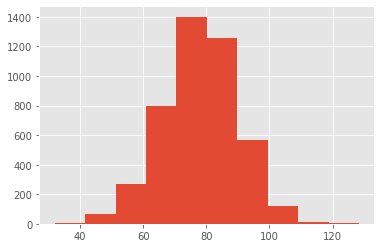

In [13]:
ms_a = fit.extract("a")["a"]
plt.hist(ms_a)

In [14]:
ms_b = fit.extract("b")["b"]

In [15]:
# サンプリングされたパラメータから予測直線を複数抽出する
df_b = pd.DataFrame([])
for i in range(40, 90, 1):
    df_b[i] = ms_a * i * ms_b  

df_b.head()

,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89
0,-2.214209e+06,-2.269565e+06,-2.324920e+06,-2.380275e+06,-2.435630e+06,-2.490986e+06,-2.546341e+06,-2.601696e+06,-2.657051e+06,-2.712407e+06,-2.767762e+06,-2.823117e+06,-2.878472e+06,-2.933828e+06,-2.989183e+06,-3.044538e+06,-3.099893e+06,-3.155249e+06,-3.210604e+06,-3.265959e+06,-3.321314e+06,-3.376669e+06,-3.432025e+06,-3.487380e+06,-3.542735e+06,-3.598090e+06,-3.653446e+06,-3.708801e+06,-3.764156e+06,-3.819511e+06,-3.874867e+06,-3.930222e+06,-3.985577e+06,-4.040932e+06,-4.096288e+06,-4.151643e+06,-4.206998e+06,-4.262353e+06,-4.317709e+06,-4.373064e+06,-4.428419e+06,-4.483774e+06,-4.539129e+06,-4.594485e+06,-4.649840e+06,-4.705195e+06,-4.760550e+06,-4.815906e+06,-4.871261e+06,-4.926616e+06
1,-9.593582e+05,-9.833422e+05,-1.007326e+06,-1.031310e+06,-1.055294e+06,-1.079278e+06,-1.103262e+06,-1.127246e+06,-1.151230e+06,-1.175214e+06,-1.199198e+06,-1.223182e+06,-1.247166e+06,-1.271150e+06,-1.295134e+06,-1.319118e+06,-1.343102e+06,-1.367085e+06,-1.391069e+06,-1.415053e+06,-1.439037e+06,-1.463021e+06,-1.487005e+06,-1.510989e+06,-1.534973e+06,-1.558957e+06,-1.582941e+06,-1.606925e+06,-1.630909e+06,-1.654893e+06,-1.678877e+06,-1.702861e+06,-1.726845e+06,-1.750829e+06,-1.774813e+06,-1.798797e+06,-1.822781e+06,-1.846765e+06,-1.870749e+06,-1.894733e+06,-1.918716e+06,-1.942700e+06,-1.966684e+06,-1.990668e+06,-2.014652e+06,-2.038636e+06,-2.062620e+06,-2.086604e+06,-2.110588e+06,-2.134572e+06
2,-1.116520e+06,-1.144433e+06,-1.172347e+06,-1.200260e+06,-1.228173e+06,-1.256086e+06,-1.283999e+06,-1.311912e+06,-1.339825e+06,-1.367738e+06,-1.395651e+06,-1.423564e+06,-1.451477e+06,-1.479390e+06,-1.507303e+06,-1.535216e+06,-1.563129e+06,-1.591042e+06,-1.618955e+06,-1.646868e+06,-1.674781e+06,-1.702694e+06,-1.730607e+06,-1.758520e+06,-1.786433e+06,-1.814346e+06,-1.842259e+06,-1.870172e+06,-1.898085e+06,-1.925998e+06,-1.953911e+06,-1.981824e+06,-2.009737e+06,-2.037650e+06,-2.065563e+06,-2.093476e+06,-2.121389e+06,-2.149302e+06,-2.177215e+06,-2.205128e+06,-2.233041e+06,-2.260954e+06,-2.288867e+06,-2.316780e+06,-2.344693e+06,-2.372606e+06,-2.400519e+06,-2.428432e+06,-2.456345e+06,-2.484258e+06
3,7.588768e+05,7.778488e+05,7.968207e+05,8.157926e+05,8.347645e+05,8.537365e+05,8.727084e+05,8.916803e+05,9.106522e+05,9.296241e+05,9.485961e+05,9.675680e+05,9.865399e+05,1.005512e+06,1.024484e+06,1.043456e+06,1.062428e+06,1.081400e+06,1.100371e+06,1.119343e+06,1.138315e+06,1.157287e+06,1.176259e+06,1.195231e+06,1.214203e+06,1.233175e+06,1.252147e+06,1.271119e+06,1.290091e+06,1.309063e+06,1.328034e+06,1.347006e+06,1.365978e+06,1.384950e+06,1.403922e+06,1.422894e+06,1.441866e+06,1.460838e+06,1.479810e+06,1.498782e+06,1.517754e+06,1.536726e+06,1.555698e+06,1.574669e+06,1.593641e+06,1.612613e+06,1.631585e+06,1.650557e+06,1.669529e+06,1.688501e+06
4,1.005445e+06,1.030581e+06,1.055718e+06,1.080854e+06,1.105990e+06,1.131126e+06,1.156262e+06,1.181398e+06,1.206534e+06,1.231670e+06,1.256807e+06,1.281943e+06,1.307079e+06,1.332215e+06,1.357351e+06,1.382487e+06,1.407623e+06,1.432759e+06,1.457896e+06,1.483032e+06,1.508168e+06,1.533304e+06,1.558440e+06,1.583576e+06,1.608712e+06,1.633849e+06,1.658985e+06,1.684121e+06,1.709257e+06,1.734393e+06,1.759529e+06,1.784665e+06,1.809801e+06,1.834938e+06,1.860074e+06,1.885210e+06,1.910346e+06,1.935482e+06,1.960618e+06,1.985754e+06,2.010890e+06,2.036027e+06,2.061163e+06,2.086299e+06,2.111435e+06,2.136571e+06,2.161707e+06,2.186843e+06,2.211980e+06,2.237116e+06


In [16]:
df_b.shape

(4500, 50)

In [17]:
# 4500個のパラメータからの結果を信頼区間内に絞る
# 50%信頼区間
low_y50, high_y50 = mstats.mquantiles(df_b, [0.25, 0.75], axis=0)
# 95%信頼区間
low_y95, high_y95 = mstats.mquantiles(df_b, [0.025, 0.975], axis=0)

In [19]:
low_y50.shape

(50,)

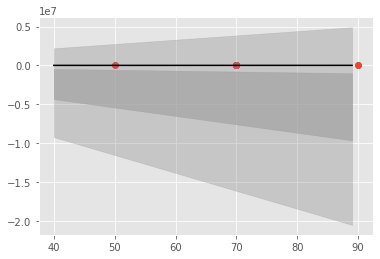

In [20]:
plt.scatter(df["space"], df["value"])
plt.fill_between(X_s, low_y50, high_y50, alpha=0.6, color="darkgray")
plt.fill_between(X_s, low_y95, high_y95, alpha=0.3, color="gray")
a = 77.96 
b = -691.7
y = a * X_s + b 

plt.plot(X_s, y, color="black")

## 予測区間

In [21]:
# ランダムデータのサンプリング分の予測値
Y_p = fit.extract("Y_s")["Y_s"]

In [23]:
Y_p.shape

(4500, 50)

In [24]:
low_y, high_y = mstats.mquantiles(Y_p, [0.025, 0.975], axis=0)

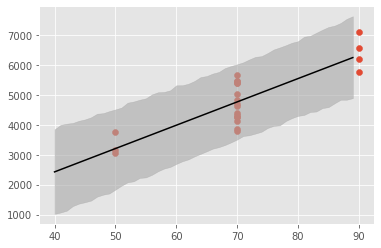

In [25]:
plt.scatter(df["space"], df["value"])
plt.fill_between(X_s, low_y, high_y, alpha=0.6, color="darkgray")
a = 77.96 
b = -691.7
y = a * X_s + b 

plt.plot(X_s, y, color="black")